## Importing packages and defining the functions 

In [4]:
import os
import random

import warnings
import pickle
warnings.filterwarnings('ignore')
from torch import nn, cuda, device
import torch
import torch.optim as optim
from torch.utils.data import Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from time import time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch.nn.functional as F
import torch.nn as nn
device = device('cuda:1')
print(device)

class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output
    
#Nested Unet

class U_net(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=1, out_ch=1):
        super(U_net, self).__init__()

        n1 = 128
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        output = F.sigmoid(output)
        return output

cuda:1


In [ ]:
# Load the unet model at its prime (when it performed the best on the validation set).
unet_model = U_net().to(device)
model_save_path = r'/home/hamad/Thyroid Saved_models/'
state_dict = torch.load(os.path.join(model_save_path, 'thyroid128_Unet_best_model.pth'))
unet_model.load_state_dict(state_dict)
unet_model.eval()


In [ ]:
from torch.autograd import Variable
imsize = 160
loader = transforms.Compose([transforms.Grayscale(),transforms.Scale(imsize), transforms.ToTensor()])

#Function for loading Image 
def image_loader(image_name):
    """load image, returns cuda tensor"""
    #image = Image.open(image_name)
    image = loader(image_name).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for network
    return image.to(device)  #assumes that you're using GPU

#calculate the Inference Time 
def get_segmented(image):
    
    start_time = time()
    image = image_loader(image)
    
    output = unet_model(image)
    time_taken = time() - start_time
    print(f'Time: {time_taken:.2f} s', end = '')
    return output

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob as glob 

In [5]:
def get_coords(gt, v = 8):
#     v = 8 # the value of safe margin 
    if np.sum(gt[:])==0:
        coords = [0, 128, 0, 128]
        return coords
    result = np.where(gt == 1)
    dW = np.abs(result[0].min()-result[0].max()) #Checking the height 
    dH = np.abs(result[1].min()-result[1].max()) #Checking the width 
    D = gt.shape[0] - np.max([dW, dH])
    if D>v:
        if dH>dW:
            dR = int(np.abs(dW - dH)/2)
            dL = np.abs(dW - dH) - dR
            coords = [result[0].min()-dR-v, result[0].max()+dL+v, result[1].min()-v, result[1].max()+v]
#             g = gt[result[0].min()-dR-v:result[0].max()+dL+v,result[1].min()-v:result[1].max()+v]
            return coords
        if dW>dH:
            dT = int(np.abs(dW - dH)/2)
            dB = np.abs(dW - dH) - dT
            coords = [result[0].min()-v, result[0].max()+v, result[1].min()-dT-v, result[1].max()+dB+v]
#             g = gt[result[0].min()-v:result[0].max()+v,result[1].min()-dT-v:result[1].max()+dB+v]
            return coords
        coords = [result[0].min()-v, result[0].max()+v, result[1].min()-v, result[1].max()+v]
#         g = gt[result[0].min()-v:result[0].max()+v,result[1].min()-v:result[1].max()+v]
        return coords
    coords = [0, 128, 0, 128]
    return coords


def make_full_contour(img,mask, winMask):
    mask = mask.astype('uint8')
    winMask = winMask.astype('uint8')
        
    kernel_0 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
    output = cv2.filter2D(mask, -1, kernel_0)
    con_ones = np.where(output > 0, 1, 0)
    con_zeros = 1 - con_ones
    
    RGB_img = np.zeros([img.shape[0],img.shape[1],3],int)
    RGB_img[:,:,0] = img*con_zeros*255 + con_ones*255
    RGB_img[:,:,2] = img*con_zeros*255
    RGB_img[:,:,1] = img*con_zeros*255
    
    kernel_0 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
    output = cv2.filter2D(winMask, -1, kernel_0)
    con_ones = np.where(output > 0, 1, 0)
    con_zeros = 1 - con_ones
    
    RGB_img[:,:,2] = RGB_img[:,:,2]*con_zeros
    RGB_img[:,:,0] = RGB_img[:,:,0]*con_zeros
    RGB_img[:,:,1] = RGB_img[:,:,1]*con_zeros + (con_ones)*255
    
    
    return RGB_img

## Reading image and Applying A-ROI Algorithm 

In [7]:
msk_path = "/home/hammad/thyroid/data/d/*.jpg"
msk_files = sorted(glob.glob(msk_path))
msk = cv2.imread(msk_files[0],0)/255
msk = np.where(msk>0.8, 1, 0)
fig = plt.figure(figsize=(10, 10))
plt.imshow(msk, 'gray')

AttributeError: 'function' object has no attribute 'glob'

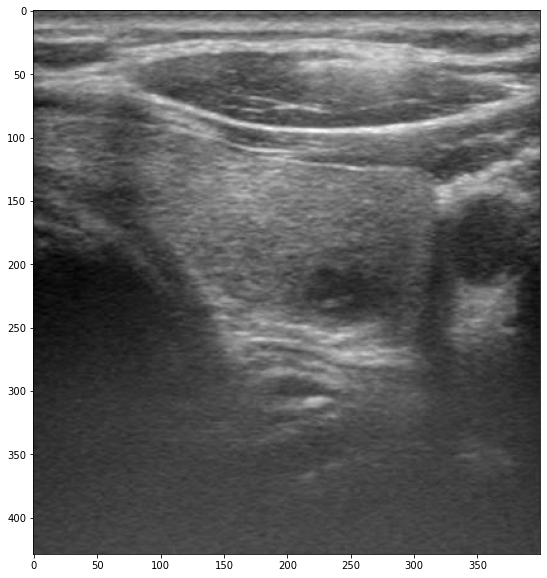

In [4]:
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "./ANN1/Image/*.jpg"
img_files = sorted(glob(img_path))
img = cv2.imread(img_files[1],0)/255



fig = plt.figure(figsize=(10, 10))
plt.imshow(img, 'gray')

In [ ]:
k = k #<<== image or mask ka index 
img = cv2.imread(img_files[k+1],0)/255
msk = cv2.imread(msk_files[k],0)/255
msk = np.where(msk>0.8, 1, 0) # converting grayscale to binary mask 
prev_msk = msk
coords = get_coords(prev_msk, 20)

roi = np.zeros_like(prev_msk)
roi[coords[0]:coords[1], coords[2]:coords[3]] = 1

rgb = make_full_contour(img,msk, roi)

fig = plt.figure(figsize=(10, 10))
prev_msk = msk
plt.imshow(rgb)
k

In [3]:
k

NameError: name 'k' is not defined

In [ ]:
roi.shape

In [ ]:
coords = get_coords(msk)
roi = np.zeros_like(msk)
roi[181:239, 151:209] = 1
plt.imshow(roi, 'gray')